# Simple Linear Model

## Introduction
This tutorial demonstrates the basic workflow of a simple linear model using TensorFlow for the so-called MNIST data-set with images of hand-written digits. We define and optimize a mathematical model in TensorFlow, while plotting & discussing the results. 

In [35]:
# Import libraries

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix

In [36]:
# Loading the MNIST Dataset
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("/tmp/data/", one_hot=True)

print('Test shape:',data.test.images.shape)
print('Train shape:',data.train.images.shape)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Test shape: (10000, 784)
Train shape: (55000, 784)


### One-Hot Encoding
The data-set has been loaded using One-Hot encoding. This means the labels have been converted from a single number to a array whose length equals the number of possible classes. All elements of the vector are zero except for the $i$'th element which is one and means the class is $i$. The One-Hot encoded labels for the first 5 images in the test-set are:

In [37]:
data.test.labels[0:5, :]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

In [38]:
# Converting the One-Hot encoded vectors to a single number by taking the index of the highest element

data.test.cls = np.array([label.argmax() for label in data.test.labels])
# Print the class of the first 5 images in test data-set
data.test.cls[0:5]

array([7, 2, 1, 0, 4])

In [39]:
# Initializing a few data variables & constants
# MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of classes, one class for each of 10 digits.
num_classes = 10

### Helper-function for plotting images
Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [40]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

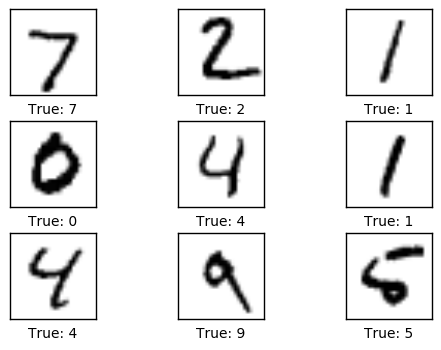

In [41]:
# Lets explore the dataset 
images = data.test.images[0:9]

cls_true = data.test.cls[0:9]    # True classes for those images.

plot_images(images=images, cls_true=cls_true)  # Plot the images and labels using our helper-function.

### Defining our TensorFlow Graph
A TensorFlow graph consists of the following parts:
1. Placeholder variables used to change the input to the graph.
2. Model variables that are going to be optimized so as to make the model perform better.
3. The model which is essentially just a mathematical function that calculates some output given the input in the placeholder variables and the model variables.
4. A cost measure that can be used to guide the optimization of the variables.
5. An optimization method which updates the variables of the model.

In [42]:
# Placeholder variable for the input images
x = tf.placeholder(tf.float32, [None, img_size_flat])

# Placeholder variable for the true labels (one hot encoded)
y_true = tf.placeholder(tf.float32, [None, num_classes])

# Placeholder variable for the true labels (Int value-actual label)
y_true_cls = tf.placeholder(tf.int64, [None])

In [43]:
# Defining our model parameters
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
biases = tf.Variable(tf.zeros([num_classes]))

In [44]:
# Simple mathematical mode - Objective function
logits = tf.matmul(x, weights) + biases

Now logits is a matrix with num_images rows and num_classes columns, where the element of the $i$'th row and $j$'th column is an estimate of how likely the $i$'th input image is to be of the $j$'th class.
So we want to normalize them so that each row of the logits matrix sums to one, and each element is limited between zero and one. This is calculated using the so-called softmax function and the result is stored in y_pred.

In [45]:
y_pred = tf.nn.softmax(logits)

#  Predicting class from the y_pred matrix by taking the index of the largest element in each row.
y_pred_cls = tf.argmax(y_pred, dimension=1)

Instructions for updating:
Use the `axis` argument instead


### Using the cross-entropy as cost-function to be optimized

The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the weights and biases of the model.

In [46]:
# TensorFlow has a built-in function for calculating the cross-entropy. 
# Note that it uses the values of the logits because it also calculates the softmax internally.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_true)

# Averaging the cross-entropy for all the image classifications to calculate the overall cost
cost = tf.reduce_mean(cross_entropy)

In [47]:
# Optimization method
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

In [48]:
# Measuring some performance measure to evaluate our model
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Lets create TensorFlow session
Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [49]:
session = tf.Session()

# Initializing all variables
session.run(tf.global_variables_initializer())
batch_size = 100      # Defining batch size for training images

# Defining Helper-function to perform optimization iterations
def optimize(num_iterations):
    for i in range(num_iterations):
        # Get a batch of training examples
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        # Put the batch into a dict with the proper names
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        # Run the optimizer using batch of training data
        session.run(optimizer, feed_dict=feed_dict_train)

feed_dict_test = {x: data.test.images, y_true: data.test.labels, y_true_cls: data.test.cls}

In [16]:
# Function for printing the classification accuracy on the test-set.
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [17]:
# Function to plot a few test images with actual & predicted values
def plot_test_sample():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    images = data.test.images
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred

    # Get the true classes for those images.
    cls_true = data.test.cls
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [18]:
# Function for plotting the weights of the model
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')
        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])

Accuracy on test-set: 9.8%


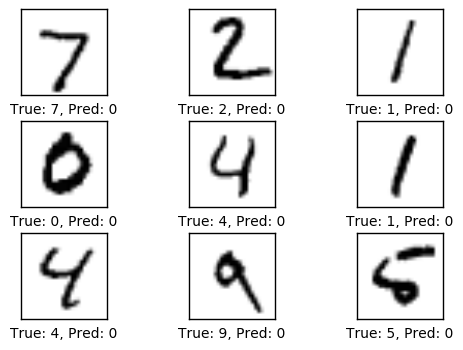

In [19]:
# Performance before any optimization
print_accuracy()
plot_test_sample()

Accuracy on test-set: 28.7%


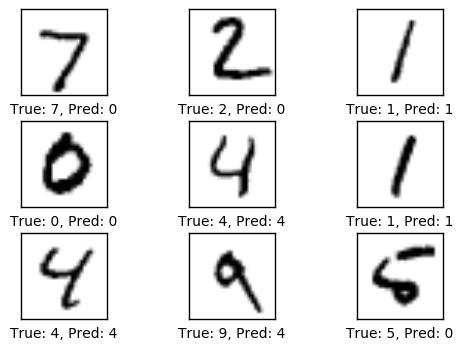

In [20]:
# Performance after 1 optimization iteration
optimize(num_iterations=1)
print_accuracy()
plot_test_sample()

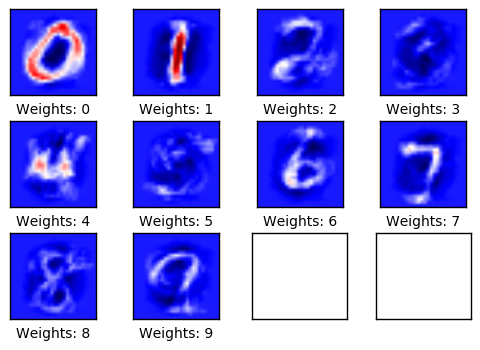

In [21]:
plot_weights()

Accuracy on test-set: 71.8%


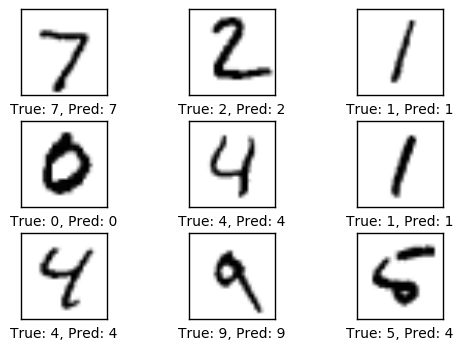

In [22]:
# Performance after 10 optimization iterations
optimize(num_iterations=9)
print_accuracy()
plot_test_sample()

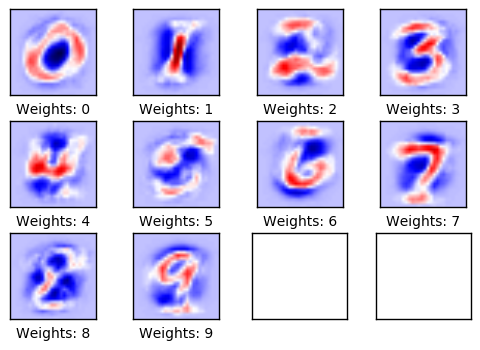

In [23]:
plot_weights()

Accuracy on test-set: 90.7%


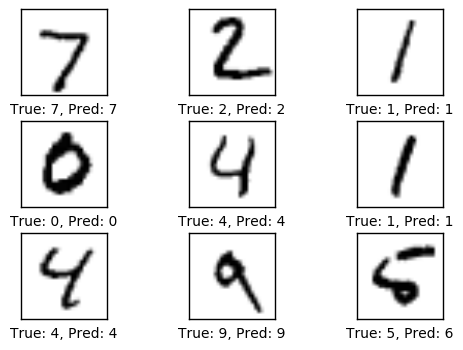

In [53]:
# Performance after 50 optimization iterations
optimize(num_iterations=49)
print_accuracy()
plot_test_sample()

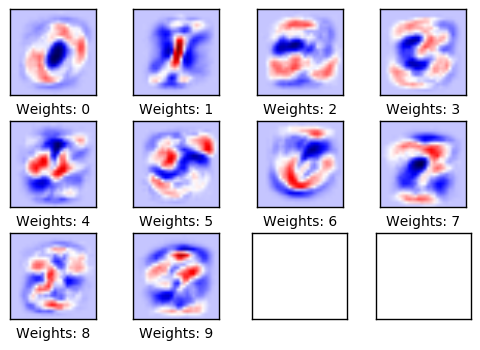

In [54]:
plot_weights()